# EXPLORATORY DATA ANALYSIS 
---

In [11]:
# LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# URL
total_data = pd.read_csv(r"..\data\raw\obesity_data.csv")
target = 'ObesityCategory'
# Example of the dataset
total_data.head(5)

,Age,Gender,Height,Weight,BMI,PhysicalActivityLevel,ObesityCategory
0,56,Male,173.575262,71.982051,23.891783,4,Normal weight
1,69,Male,164.127306,89.959256,33.395209,2,Obese
2,46,Female,168.072202,72.930629,25.817737,4,Overweight
3,32,Male,168.459633,84.886912,29.912247,3,Overweight
4,60,Male,183.568568,69.038945,20.487903,3,Normal weight


## Step 1: Multivariable analysis
---

### 1.0. Creating numerical categoric variables:

Next, the categoric variables will be transformed into numerical-categoric variables for its use.

In [12]:
# Variable 1 - Gender
total_data["Gender"] = pd.factorize(total_data['Gender'])[0]

# Variable 2 - ObesityCategory (target)
values = {
    'Underweight': 0,
    'Normal weight': 1,
    'Overweight': 2,
    'Obese': 3 }
# Transform variable into numerical categoric using defined values
total_data['ObesityCategory'] = total_data['ObesityCategory'].replace(values)

# Show results
total_data.head(3)


,Age,Gender,Height,Weight,BMI,PhysicalActivityLevel,ObesityCategory
0,56,0,173.575262,71.982051,23.891783,4,1
1,69,0,164.127306,89.959256,33.395209,2,3
2,46,1,168.072202,72.930629,25.817737,4,2


The categorized variables are the following:

1. For Gender:
- Male = 0
- Female = 1

2. For ObesityCategory:
- Underweight = 0
- Normal weight = 1
- Overweigth = 2 
- Obese = 3

The purpouse of the manual factorization is to provide a better correlation between predictors and target variables.


### 1.1. Numerical - Numerical analysis between predictors and target:

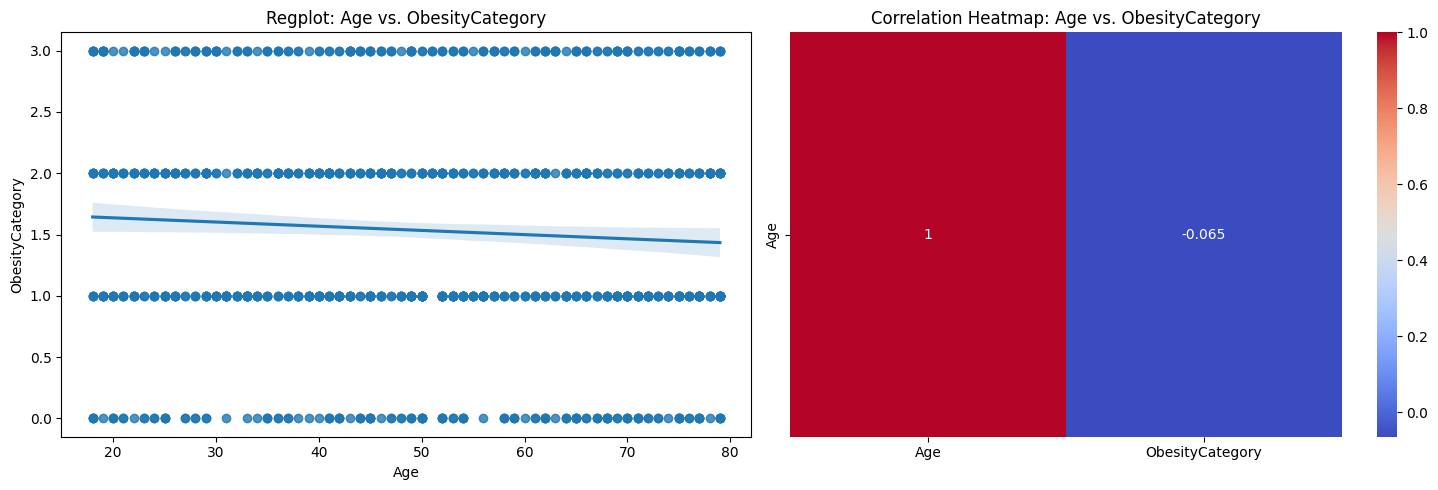

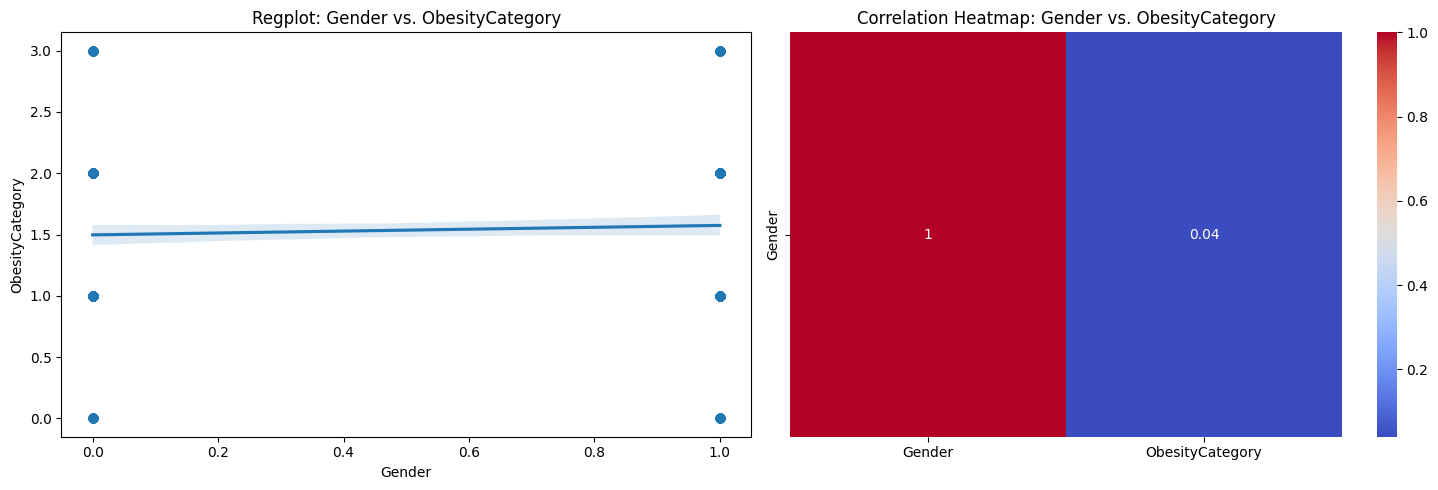

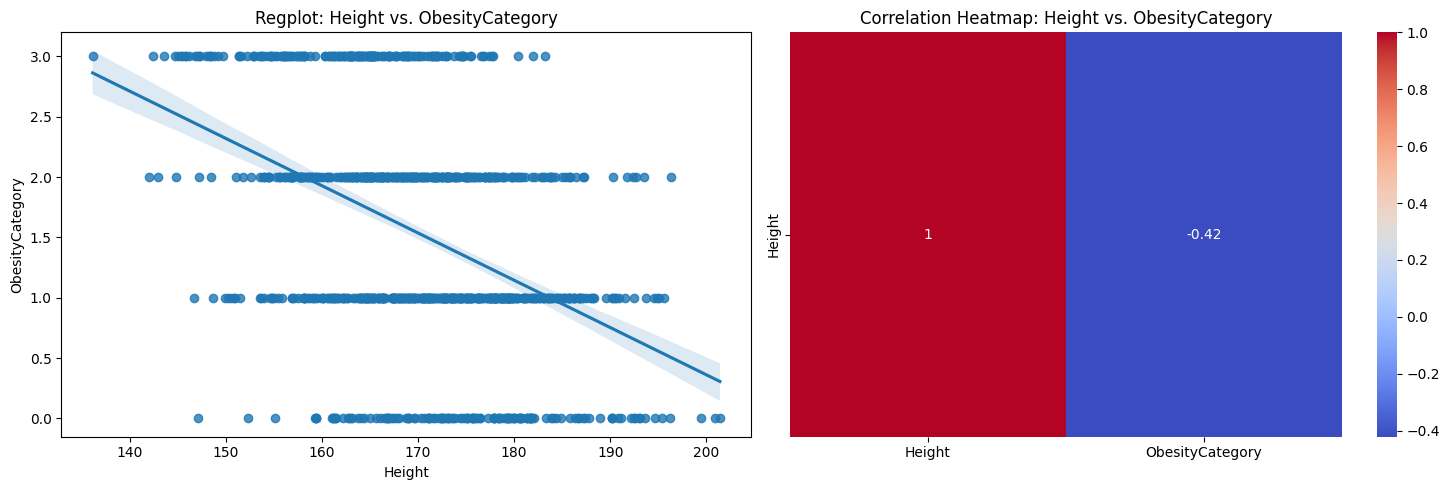

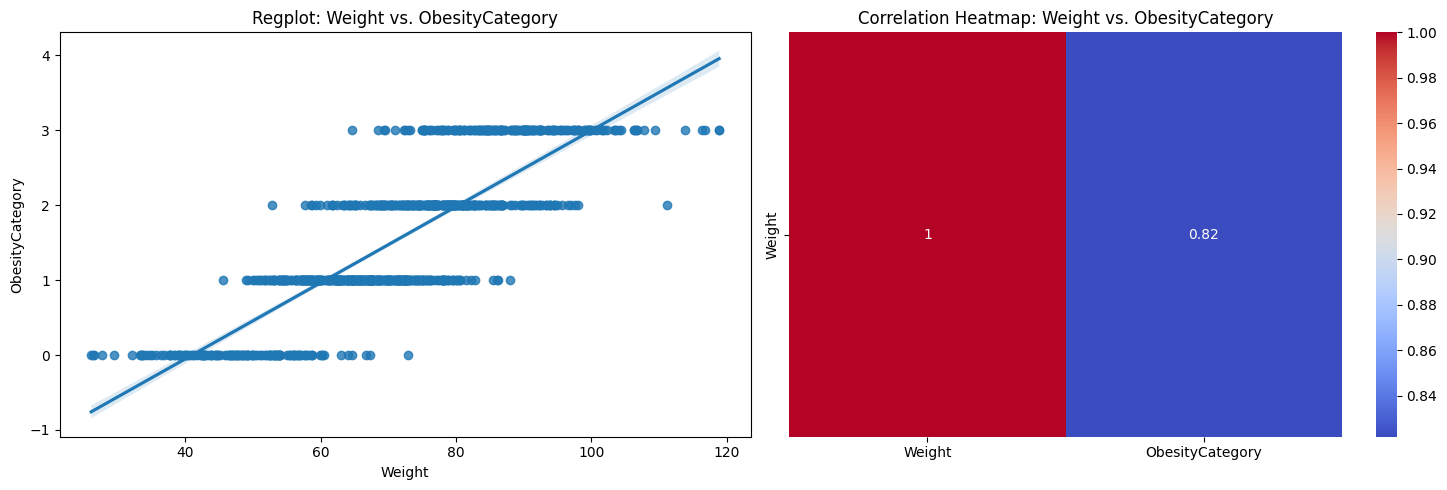

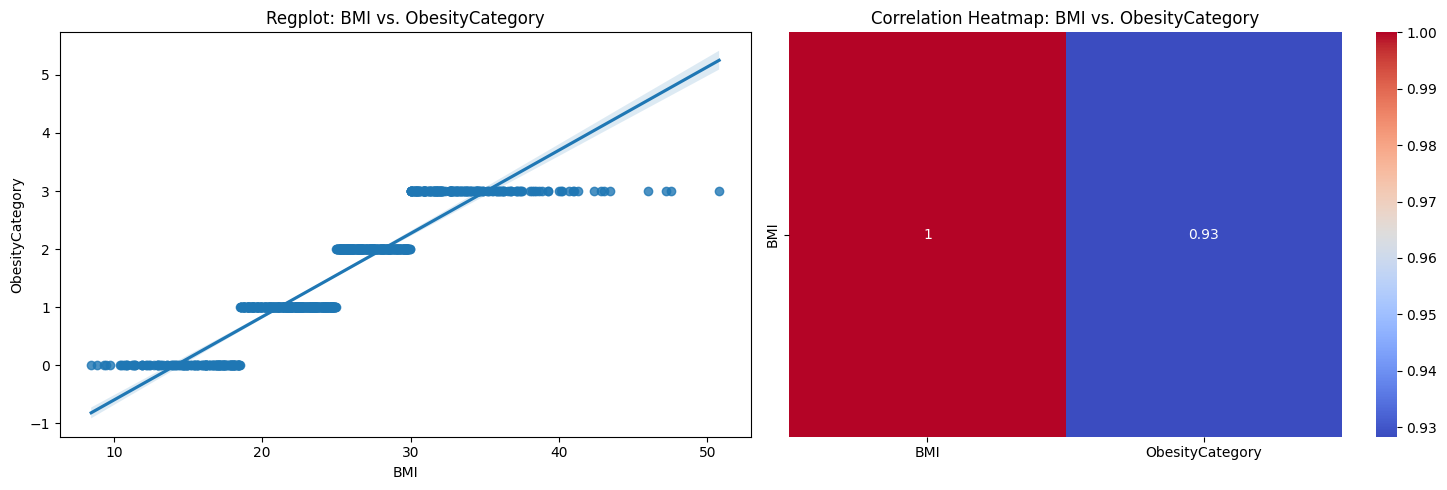

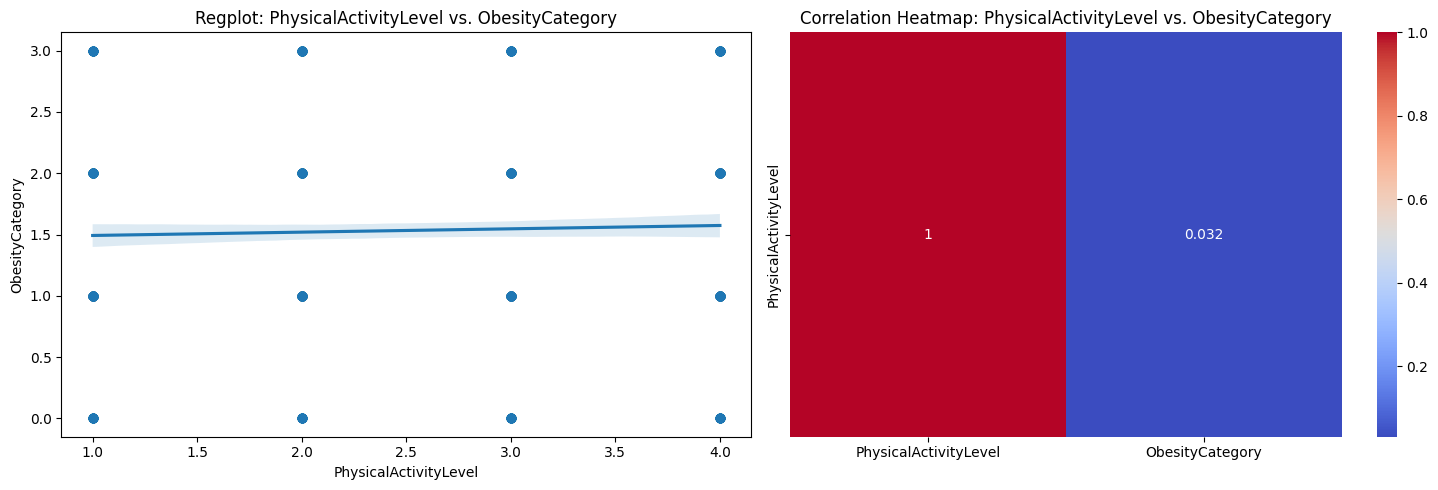

In [13]:
for column in total_data:
    #make exception for target column
    if column == target:
        continue
    
    # Setting up the subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    # Regression plot
    sns.regplot(x=column, y=target, data=total_data, ax=axes[0])
    axes[0].set_title('Regplot: {} vs. {}'.format(column, target))
    # Heatmap of correlation
    sns.heatmap(total_data[[column, target]].corr().iloc[0:1, :], annot=True, cmap='coolwarm', ax=axes[1])
    axes[1].set_title('Correlation Heatmap: {} vs. {}'.format(column, target))
    # Show the plot for each column with target_1
    plt.tight_layout()
    plt.show()

The numerical-numerical showed that the correlation between variables and the target is high.

- BMI: 0,93
- Weight: 0,82
- Height: 0,42
- Age: 0,065
- Gender: 0,04
- Physicalactivity: 0,032



### 1.2. General correlation heatmap:

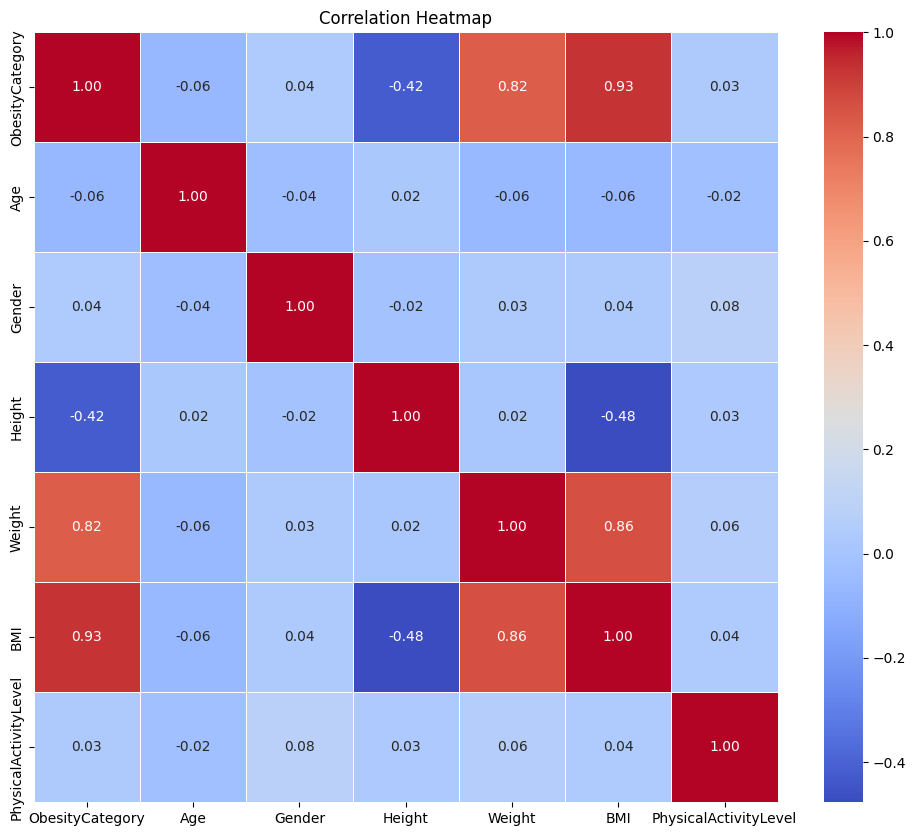

In [14]:
selection = [target, "Age","Gender","Height","Weight","BMI","PhysicalActivityLevel"]
heatmap_data = total_data[selection]
correlation_matrix = heatmap_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Show the plot
plt.title('Correlation Heatmap')
plt.show()

### 1.3. General dataset scatter plot:

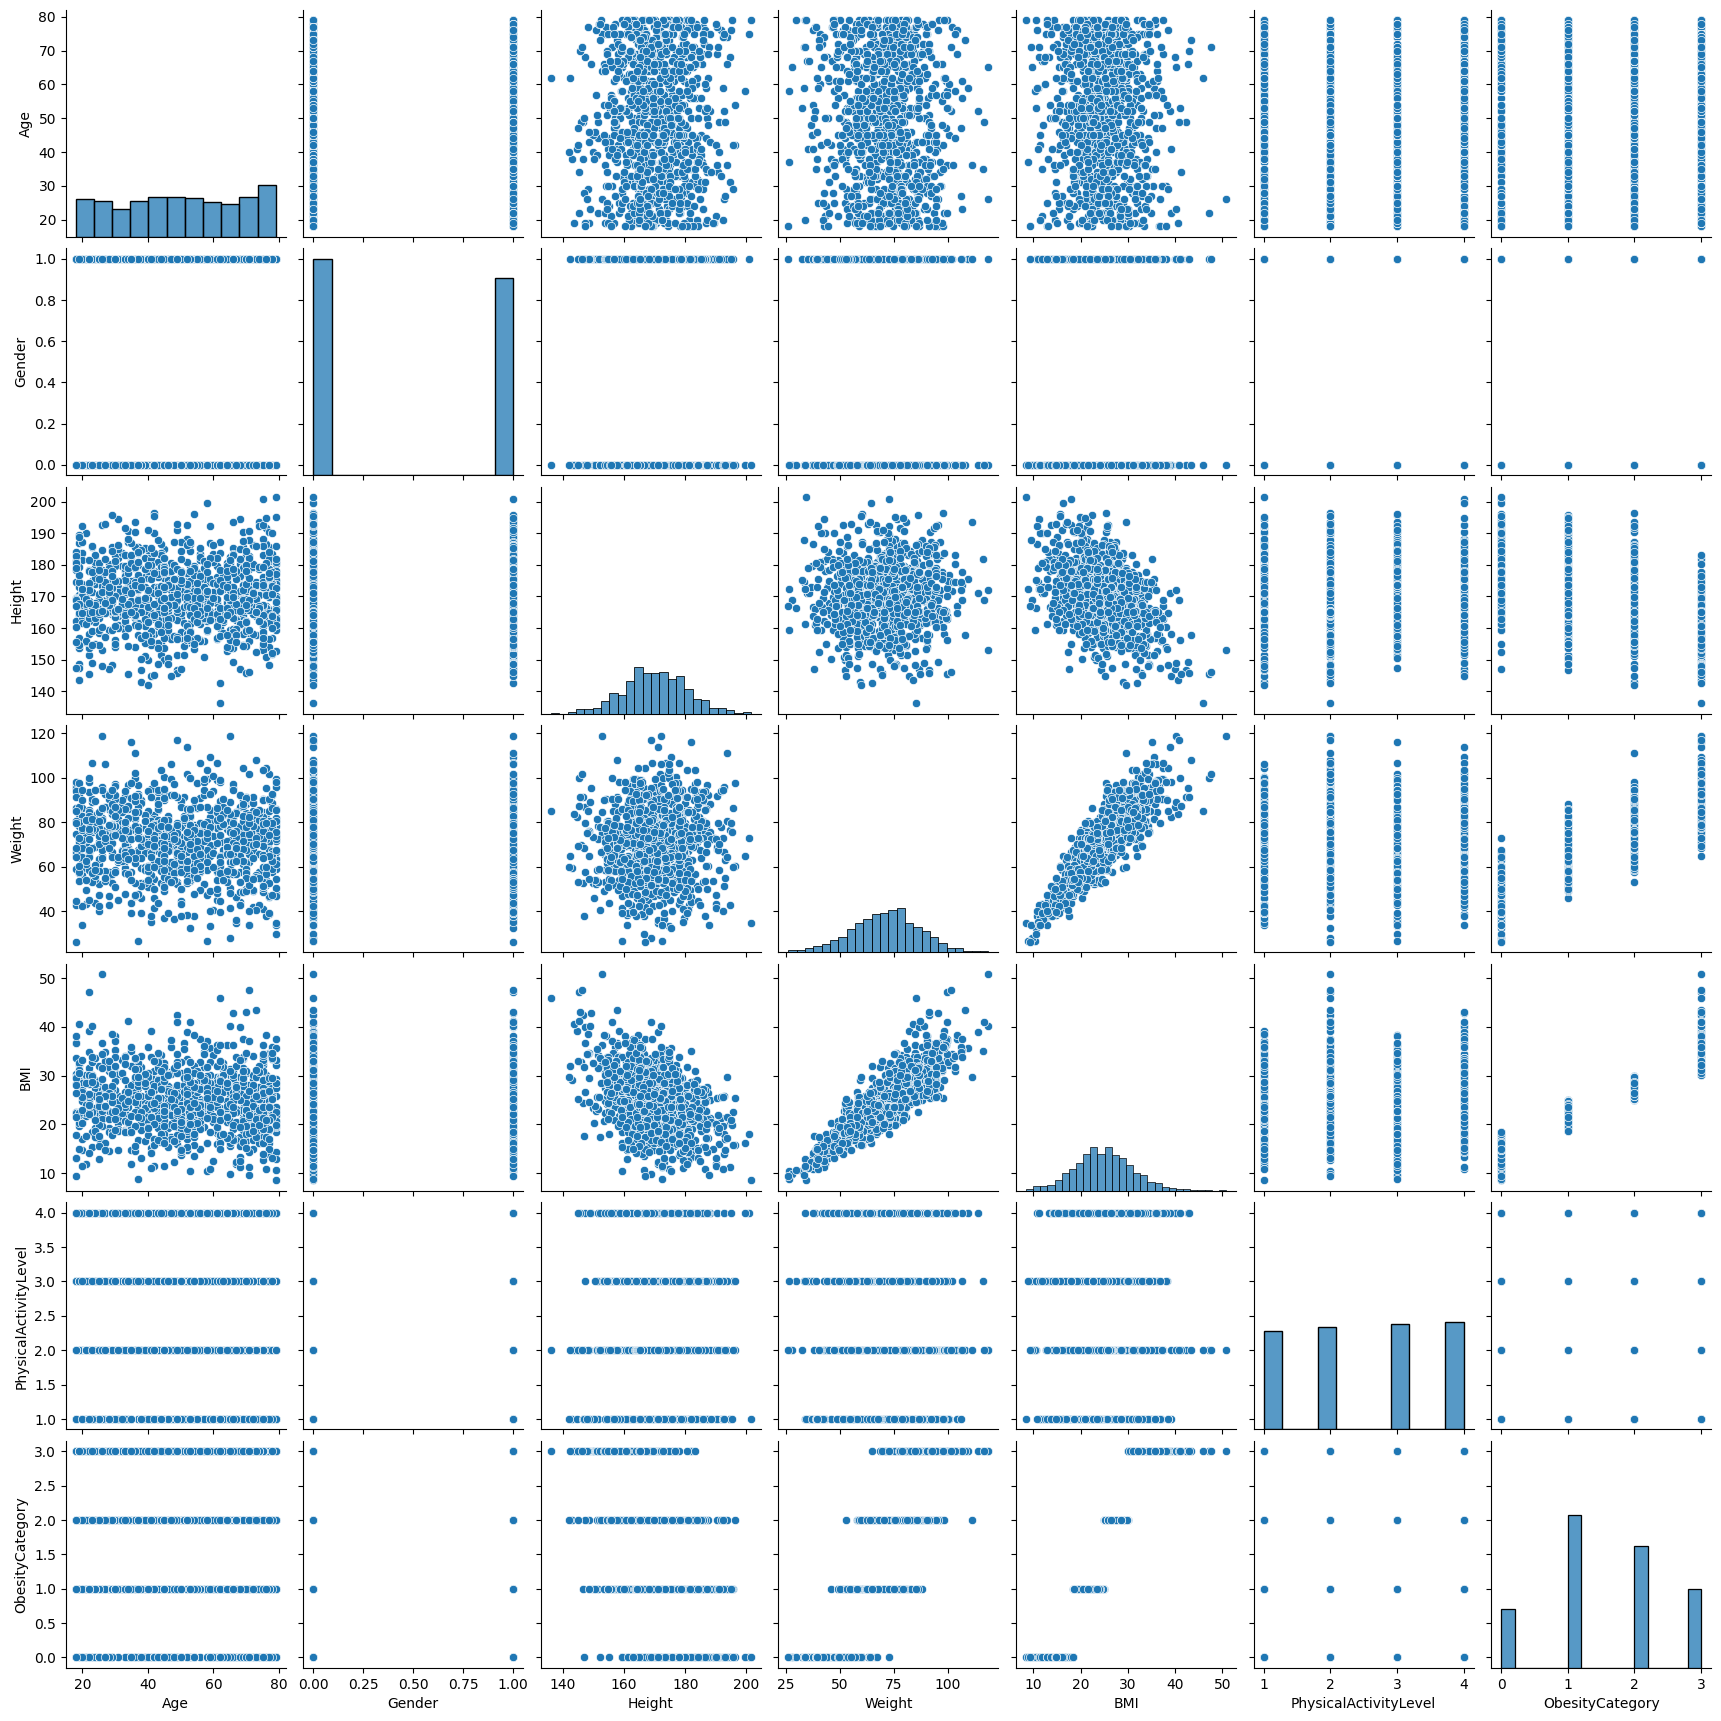

In [15]:
# General pairplot
sns.pairplot(data = total_data)

### 1.4. Early split (before feature engineering)

_NOTE: The Train / Test division will use the seed no. 42._

In [16]:
# Select the numeric variables
numeric_variables = total_data.select_dtypes(include=['float64', 'int64']).columns
numeric_variables = numeric_variables[numeric_variables != target]
# Separate the target and the predictors
x = total_data.drop(target, axis=1)[numeric_variables]
y = total_data[target]
# Divide the dataset into train / test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
X_train[target] = list(y_train)
X_test[target] = list(y_test)
# # Create the csv documents for store
X_train.to_csv(r'..\data\interim\early_x_train.csv', index = False )
X_test.to_csv(r'..\data\interim\early_x_test.csv', index = False )


## STEP 2: FEATURE ENGINEERING

---

### 2.1. Outiler analysis:

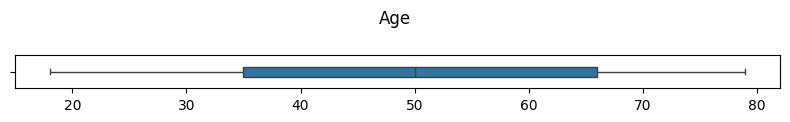

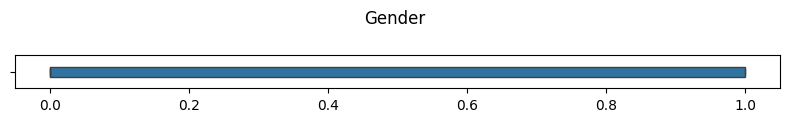

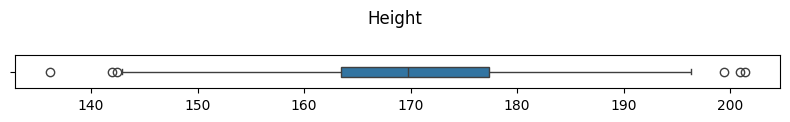

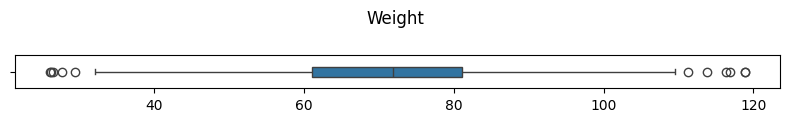

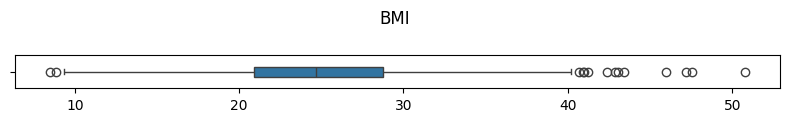

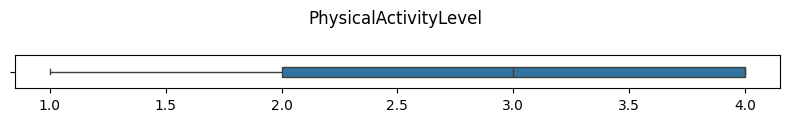

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,49.857000,18.114267,18.000000,35.000000,50.000000,66.000000,79.000000
Gender,1000.0,0.477000,0.499721,0.000000,0.000000,0.000000,1.000000,1.000000
Height,1000.0,170.052417,10.309971,136.115719,163.514205,169.801665,177.353596,201.419670
Weight,1000.0,71.205769,15.509849,26.065730,61.129629,71.929072,81.133746,118.907366
BMI,1000.0,24.888317,6.193912,8.470572,20.918068,24.698647,28.732132,50.791898
PhysicalActivityLevel,1000.0,2.534000,1.116284,1.000000,2.000000,3.000000,4.000000,4.000000
ObesityCategory,1000.0,1.534000,0.957999,0.000000,1.000000,1.000000,2.000000,3.000000


In [17]:
# CUSTOM FUNCTION for standard outlier analysis (graph and description)
def outlier_analysis(dataframe,target):
    numerical_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns
    numerical_columns = numerical_columns[numerical_columns != target]
    for column in numerical_columns:
        fig, axis = plt.subplots(figsize=(8, 1.2))
        sns.boxplot(ax=axis, data=dataframe, x=column, width=0.3).set(xlabel=None)
        fig.suptitle(column)
        plt.tight_layout()
        plt.show()
    # Return the describe dataframe    
    return dataframe.describe().T

outlier_analysis(total_data,target)

This standard analysis indicates the presence of outliers in three columns. Height, Weight and BMI includes records that can be considered outliers. Extra analysis will be performed:

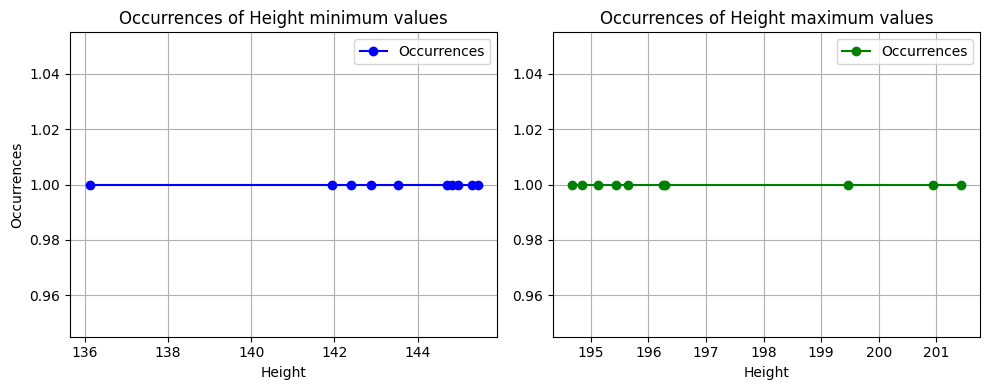

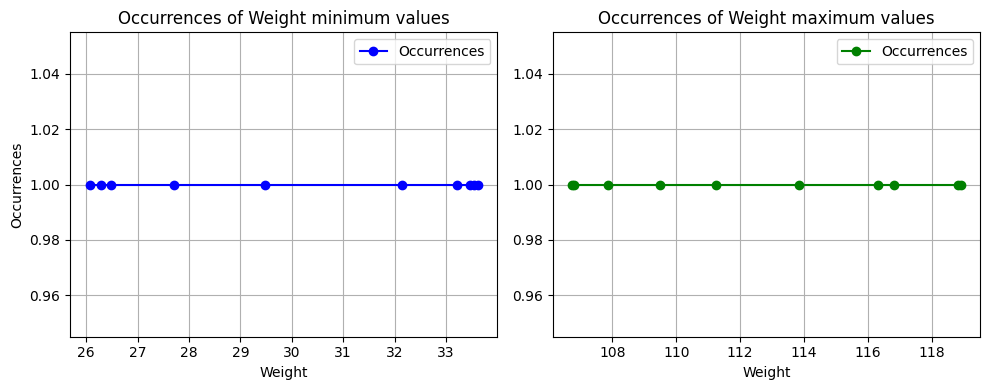

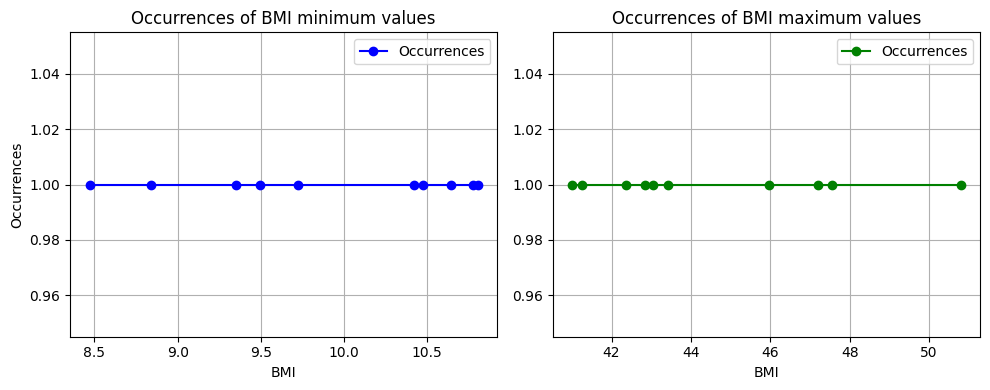

In [18]:
def min_max_records(dataframe, target, record_num):
    for x in dataframe.columns:
        if x == target:
            continue
        # VARIABLES FOR PLOTTING
        min_values = np.sort(dataframe[x].unique())[:record_num]
        max_values = np.sort(dataframe[x].unique())[-record_num:]
        min_records = [(dataframe[x] == value).sum() for value in min_values]
        max_records = [(dataframe[x] == value).sum() for value in max_values]

        # PLOT WITH 2 SUBPLOTS
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

        # MIN VALUE PLOT
        ax1.plot(min_values, min_records, linestyle='-', color='b', label='Occurrences', marker='o')
        ax1.set_xlabel(f'{x}')
        ax1.set_ylabel('Occurrences')
        ax1.set_title(f'Occurrences of {x} minimum values')
        ax1.grid(True)
        ax1.legend()

        # MAX VALUE PLOT
        ax2.plot(max_values, max_records, linestyle='-', color='g', label='Occurrences', marker='o')
        ax2.set_xlabel(f'{x}')
        ax2.set_title(f'Occurrences of {x} maximum values')
        ax2.grid(True)
        ax2.legend()

        fig.tight_layout()
        plt.show()

outlier_columns = ['Height','Weight','BMI']
min_max_records(total_data[outlier_columns], target, 10)

After the graph analysis, it is possible to determine that the values intialiy considered outliers can be taken into the dataset. This is due to the fact that are values that are humanly possible. In other words, **the outliers are going to be kept in the dataset**.

### Step 3: Feature selection
_NOTE: After the analysis it is determined that there are no viable options for merging variables or generating new features._



### 3.1. Train / Test division

Since there were no modifications in the dataset after the early split, there is no need to create a new split.

### 3.3. Selection of features

In [19]:
selection_model = SelectKBest(f_classif, k = 4)
selection_model.fit(X_train, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])
X_train_sel.head()

c:\Users\Francesc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


,Height,Weight,BMI,ObesityCategory
0,168.280866,89.904528,31.747687,3.0
1,171.420509,62.943867,21.420414,1.0
2,184.867471,42.457383,12.423164,0.0
3,162.567100,64.594380,24.441588,1.0
4,162.385378,83.474228,31.656184,3.0


### 3.3. Saving the modified dataset

In [20]:
X_train_sel[target] = list(y_train)
X_test_sel[target] = list(y_test)
X_train_sel.to_csv(r"..\data\processed\x_train.csv", index=False)
X_test_sel.to_csv(r"..\data\processed\x_test.csv", index=False)

---
## GENERAL CONCLUSIONS OF EDA ANALYSIS

With this step, the Exploratory Data Analysis (EDA) is considered complete. Below are concise bullet points summarizing the main conclusions:

**2. General Dataset Conclusions:**

**_Dataset Overview:_**
- The dataset encompasses 1000 entries and seven columns, including six feature columns and a target variable labeled 'ObesityCategory'.

**_Data Characteristics:_**
- Four predictive variables are numeric and two are categoric . The target variable 'ObesityCategory' is numeric categorical, with four possible outcomes.

**_Data Quality:_**
- The dataset is complete with no missing values. No duplicate entries are present, and the distribution of most variables aligns with normality. 

**2. Summary of Correlations Between Predictor Variables and the Target Variable (Outcome):**

|  Variable           | Correlation  |
|---------------------|--------------|
| BMI         | 0.22         | 
| Weight             | 0.47         | 
| Height       | 0.07         | 
| Age       | 0.07         | 
| Gender             | 0.13         | 
| PhysicalActivityLevel	                 | 0.29         | 


**3. Outliers and Variable Analysis:**

- There are values that can be considered statistically outliers in the columns Weight, Height and BMI. However, after a deep anaylsis of the values, it was determined that the mentioned values can be taken into the analysis.


**4. Feature selection:**

- There are no viable options for merging variables or generating new features.

- The selection of best features provided the following result: 'Weight', 'Height' and 'BMI'

**5. saved files:**

The following files were saved during the EDA analysis:

- early_x - the dataset without any change.

- x - the dataset with feature selection